In [66]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from geopy.distance import geodesic

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

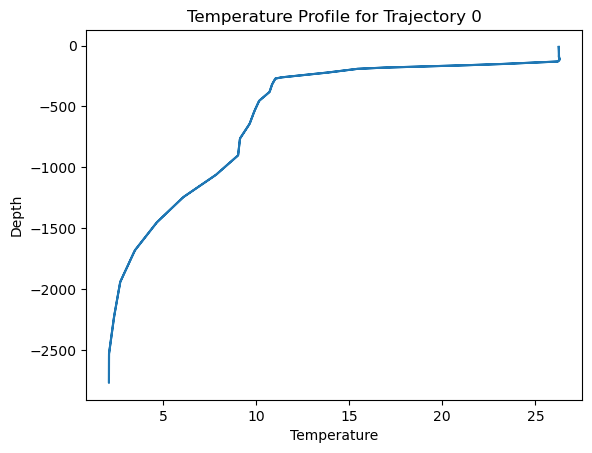

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:12:00'), 'temperature': 26.256418228149414, 'salinity': 34.966346740722656, 'z': -11.0, 'trajectory': 38, 'obs': 0}


In [67]:
"""
This cell just loads the data and puts it all first in a dataframe, and then in a data dictionary. I'm not sure why it works with a datadict but
I checked it with print statements and the data is fine afaik.
"""
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect dataset
print(ds)

# Count the number of trajectories and observations
num_trajectories = ds.sizes['trajectory']
num_observations = ds.sizes['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Reshape dataset to avoid looping
ds_stacked = ds.stack(points=("trajectory", "obs")).reset_index("points")

# Convert to a dictionary efficiently
df = ds_stacked[['lat', 'lon', 'time', 'temperature', 'salinity', 'z']].to_dataframe()
df = df.reset_index(drop=True)  # Drop unnecessary index columns
data = df.to_dict(orient='records')

# Check the first profile
print(data[0])


In [68]:
print(data[80])
print(data[100])
print(data[150])
print(data[220])
print(data[300])
print(data[400])

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:25:20'), 'temperature': 9.099099159240723, 'salinity': 35.17838668823242, 'z': -811.0, 'trajectory': 38, 'obs': 80}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:28:40'), 'temperature': 8.224143981933594, 'salinity': 35.172183990478516, 'z': -1011.0, 'trajectory': 38, 'obs': 100}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:37:00'), 'temperature': 4.367069721221924, 'salinity': 34.9659538269043, 'z': -1511.0, 'trajectory': 38, 'obs': 150}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:48:40'), 'temperature': 2.3896257877349854, 'salinity': 34.760215759277344, 'z': -2211.0, 'trajectory': 38, 'obs': 220}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-18 00:02:00'), 'temperature': 2.102433443069458, 'salinity': 34.77864074707031, 'z': -2531.0, 'traj

c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


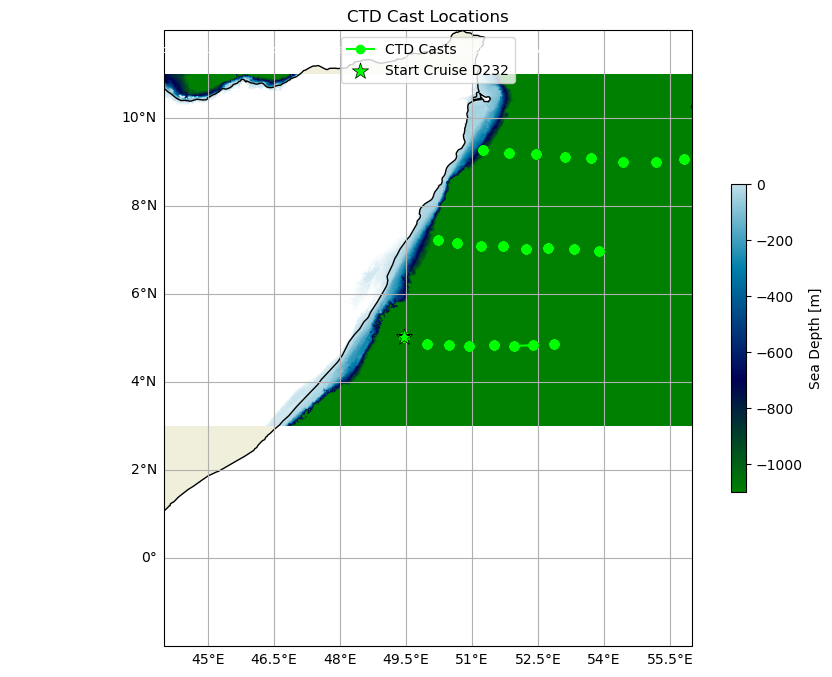

In [69]:
"""
This cell loads the bathymetry data and plots all the different lat/lon points of the CTD casts over the map that is plotted using the 
bathymetry. 
"""
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [70]:
"""
This cell defines constants and a function that calculates the density per profile, meaning per CTD cast, from the salinity and temperature.
For this, the relation that is given in tutorial 3 (I believe) is used. If plot is set to true,
t also poops out a plot of the density as a function of depth for every profile. 
"""
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)
def calc_density(profile, plot=False):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = profile['salinity']
    T = profile['temperature']
    depth = profile['depth']

    # Reference salinity and temperature (surface value)
    S0 = S[0]
    T0 = T[0]

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # Plot
    if plot==True:
        plt.figure(figsize=(8, 6))
        plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
        plt.xlabel('Density (kg/m³)')
        plt.ylabel('Depth (m)')
        plt.title('Density Profile')
        plt.grid()
        plt.legend()
        plt.show()

    return dens

In [71]:
"""
This cell processes CTD cast data into organized profiles. It:

1. Groups measurements by trajectory (CTD cast).
2. Separates downcast (descending) and upcast (ascending) sections.
3. Filters out invalid measurements (NaNs) and small depth fluctuations.
4. Provides sorting options:
   - "cast": Sorts downcast/upcast sections separately.
   - "depth": Sorts all measurements by depth (mixes casts).
5. Calculates density using either:
   - A simple linear approximation.
   - A more accurate function (e.g., TEOS-10).
6. Preserves metadata (location, time, trajectory, transect ID).

Processing modes:
- "downcast": Only descending measurements.
- "upcast": Only ascending measurements.
- "both": Both casts, with sorting control.

Output: A list of profiles with depth, salinity, temperature, density, and metadata.
"""

from collections import defaultdict
import numpy as np

# Configuration parameters
PROCESSING_MODE = "downcast"          # Options: "both", "downcast", "upcast"
COMBINED_SORT_MODE = "depth"       # Options: "cast" (preserve sections), "depth" (full sort)
MIN_DEPTH_CHANGE = 0.5            # meters, minimum depth change for cast detection
SORT_TRAJECTORIES = True          # Sort stations along transect
USE_SIMPLE_DENSITY = False        # Use linear density approximation

def detect_cast_sections(depths, min_change=0.5):
    """Identify downcast/upcast sections using depth changes"""
    sections = []
    current_dir = None
    current_start = 0
    
    for i in range(1, len(depths)):
        delta = depths[i] - depths[i-1]
        
        if abs(delta) < min_change:
            continue  # Ignore small fluctuations
            
        new_dir = 'down' if delta > 0 else 'up'
        
        if new_dir != current_dir:
            if current_dir is not None:
                sections.append((current_dir, current_start, i-1))
            current_dir = new_dir
            current_start = i
    
    if current_dir is not None:
        sections.append((current_dir, current_start, len(depths)-1))
    
    return sections
def process_cast(valid_obs, mode):
    """Process downcast or upcast data with proper sorting"""
    depths = np.array([obs['z'] for obs in valid_obs])
    sections = detect_cast_sections(depths, MIN_DEPTH_CHANGE)
    
    processed = []
    # Find the main cast section based on mode
    target_dir = mode.replace('cast', '').lower()  # handles "downcast"/"upcast"
    
    for dir, start, end in sections:
        if dir == target_dir:
            section_obs = valid_obs[start:end+1]
            section_depths = [obs['z'] for obs in section_obs]
            
            # Sort by depth (down=ascending, up=descending)
            sort_idx = np.argsort(section_depths) if dir == 'down' else np.argsort(-np.array(section_depths))
            
            for i in sort_idx:
                obs = section_obs[i]
                obs['cast_direction'] = dir
                processed.append(obs)
            break  # Take only the first continuous section
    
    return processed
def process_combined_data(valid_obs):
    """Handle combined cast processing with sorting options"""
    if COMBINED_SORT_MODE == "depth":
        # Full depth sorting (original cell behavior)
        sorted_obs = sorted(valid_obs, key=lambda x: x['z'])
        for obs in sorted_obs:
            obs['cast_direction'] = 'combined'
        return sorted_obs
    
    # Cast-based processing (improved cell behavior)
    depths = np.array([obs['z'] for obs in valid_obs])
    sections = detect_cast_sections(depths, MIN_DEPTH_CHANGE)
    
    processed = []
    for dir, start, end in sections:
        section_obs = valid_obs[start:end+1]
        section_depths = [obs['z'] for obs in section_obs]
        
        # Sort section appropriately
        sort_idx = np.argsort(section_depths) if dir == 'down' else np.argsort(-np.array(section_depths))
        
        for i in sort_idx:
            obs = section_obs[i]
            obs['cast_direction'] = dir
            processed.append(obs)
    
    return processed

# Group data by trajectory
grouped_data = defaultdict(list)
for obs in data:
    grouped_data[obs['trajectory']].append(obs)

profiles = []
for trajectory in sorted(grouped_data.keys()) if SORT_TRAJECTORIES else grouped_data.keys():
    observations = grouped_data[trajectory]
    
    # Sort by time and filter NaNs
    time_sorted = sorted(observations, key=lambda x: x['time'])
    valid_obs = [obs for obs in time_sorted if not any(
        np.isnan(obs[k]) for k in ['salinity', 'temperature', 'z'])]
    
    if not valid_obs:
        continue
    
    # Process based on mode
    if PROCESSING_MODE == "both":
        processed_obs = process_combined_data(valid_obs)
    else:
        processed_obs = process_cast(valid_obs, PROCESSING_MODE)
        
    if not processed_obs:
        continue
        
    # Create final arrays
    z = np.array([obs['z'] for obs in processed_obs])
    salinity = np.array([obs['salinity'] for obs in processed_obs])
    temperature = np.array([obs['temperature'] for obs in processed_obs])
    
    # Density calculation
    if USE_SIMPLE_DENSITY:
        dens = 1027 * (1 - 1e-4*(temperature - temperature[0]) + 7e-4*(salinity - salinity[0]))
    else:
        dens = calc_density({
            'salinity': salinity,
            'temperature': temperature,
            'depth': z
        })
    
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'salinity': salinity,
        'temperature': temperature,
        'depth': z,
        'lat': processed_obs[0]['lat'],
        'lon': processed_obs[0]['lon'],
        'time': processed_obs[0]['time'],
        'transect_id': 3 if processed_obs[0]['lat'] > 8 else 2 if processed_obs[0]['lat'] > 6 else 1,
        'cast_directions': [obs['cast_direction'] for obs in processed_obs]
    })

# Print verification
if profiles:
    print(f"Processing Mode: {PROCESSING_MODE} ({COMBINED_SORT_MODE} sort)")
    print(f"First profile depth sequence:", profiles[0]['depth'][::len(profiles[0]['depth'])//10])
    print(f"Cast directions:", profiles[0]['cast_directions'][::len(profiles[0]['cast_directions'])//10])


Processing Mode: downcast (depth sort)
First profile depth sequence: [-2761. -2491. -2221. -1951. -1681. -1411. -1141.  -871.  -601.  -331.
   -61.]
Cast directions: ['down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down']


In [72]:
data

[{'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:00'),
  'temperature': 26.256418228149414,
  'salinity': 34.966346740722656,
  'z': -11.0,
  'trajectory': 38,
  'obs': 0},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:10'),
  'temperature': 26.260557174682617,
  'salinity': 34.970802307128906,
  'z': -21.0,
  'trajectory': 38,
  'obs': 1},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:20'),
  'temperature': 26.26323127746582,
  'salinity': 34.97873306274414,
  'z': -31.0,
  'trajectory': 38,
  'obs': 2},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:30'),
  'temperature': 26.26406478881836,
  'salinity': 34.988609313964844,
  'z': -41.0,
  'trajectory': 38,
  'obs': 3},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:40'),
  'temperature': 26.265293

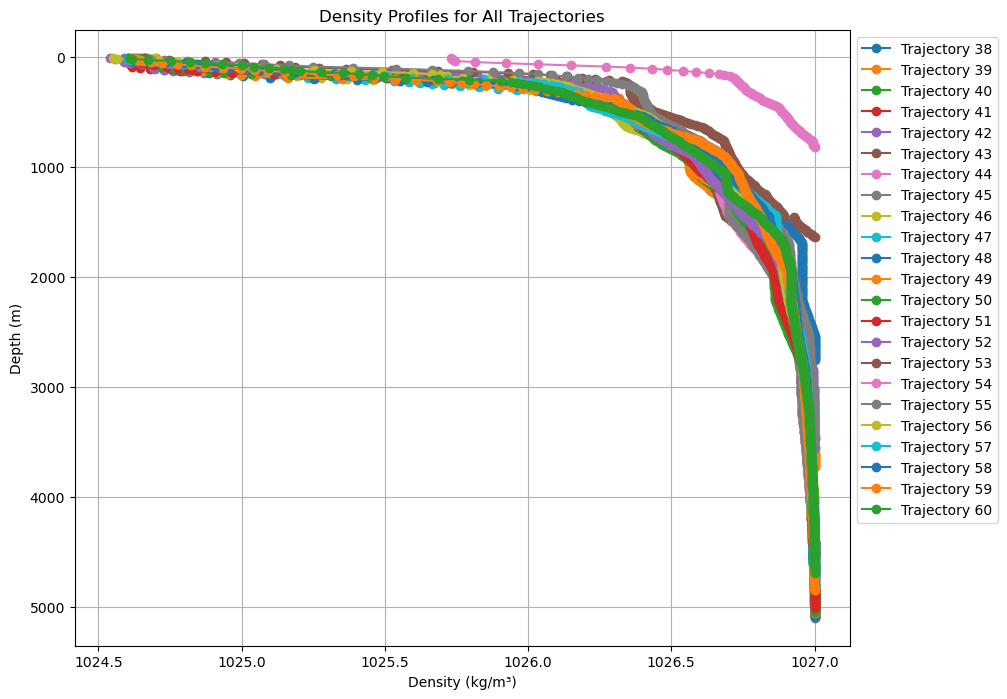

In [73]:
"""
This cell plots the density profiles of all the different CTD casts. It uses the previously defined function to calculate the density and then plots it.
"""
plt.figure(figsize=(10, 8))

for profile in profiles:
    dens = calc_density(profile, plot=False)
    depth = profile['depth']
    plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")

plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profiles for All Trajectories')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.gca().invert_yaxis()

# Save the plot
plt.savefig('density_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:
# Extract density and depth arrays for all stations
density_profiles = [profile['density'] for profile in profiles]
depth_profiles = [profile['depth'] for profile in profiles]

# Ensure all profiles have the same depth levels (interpolate if necessary)
# Example: Interpolate to a common depth grid (adjust resolution as needed)
common_depth = np.linspace(np.min([np.min(z) for z in depth_profiles]), 
                           np.max([np.max(z) for z in depth_profiles]), 
                           100)
density_interp = []
for dens, z in zip(density_profiles, depth_profiles):
    dens_interp = np.interp(common_depth, z, dens)
    density_interp.append(dens_interp)

density_interp = np.array(density_interp)  # Shape: (n_stations, n_depth_levels)



In [75]:
def plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature', n_interp=1000):
    """
    Plot cross-sections for specified transects with bathymetry masking.
    Uses custom colormaps and reference point distances in kilometers.
    """
    colormaps = {
        'temperature': cmocean.cm.thermal,
        'salinity': cmocean.cm.haline,
        'density': cmocean.cm.dense
    }

    # Define reference points for each transect (lon, lat)
    shore_points = {
        1: (48.21, 4.97),
        2: (49.54, 7.29),
        3: (50.72, 9.31)
    }

    for transect_id in transect_ids:
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue

        # Get reference point
        try:
            lon0, lat0 = shore_points[transect_id]
        except KeyError:
            raise ValueError(f"No reference point defined for transect {transect_id}")

        # Calculate distances from reference point
        distances_km = []
        for p in transect_profiles:
            profile_point = (p['lat'], p['lon'])
            reference_point = (lat0, lon0)
            distances_km.append(geodesic(profile_point, reference_point).kilometers)

        # Sort profiles by distance from reference
        sorted_indices = np.argsort(distances_km)
        transect_profiles = [transect_profiles[i] for i in sorted_indices]
        distances_km = np.array(distances_km)[sorted_indices].tolist()
        print(f"--- Debug: Shallowest Measurement Depths for Transect {transect_id} ---")
        for i, p in enumerate(transect_profiles):
            min_depth = np.min(np.abs(p['depth']))  # Find the shallowest depth
            print(f"Station {i+1} at {distances_km[i]:.2f} km: Shallowest depth = {min_depth:.2f} m")
            print("------------------------------------------------------------")

        # Extract coordinates and depths
        lons = [p['lon'] for p in transect_profiles]
        lats = [p['lat'] for p in transect_profiles]
        ctd_depths = [np.abs(p['depth']) for p in transect_profiles]

        # Get bathymetry for sorted profiles
        bathymetry = []
        for lon, lat in zip(lons, lats):
            elev = bathy.elevation.sel(lon=lon, lat=lat, method="nearest").values
            bathymetry.append(-elev if elev < 0 else elev)
        bathymetry = np.array(bathymetry)

        # Create depth grid
        max_depth = np.nanmax(bathymetry)
        common_z = np.linspace(0, max_depth, 100)

        # Create interpolation grid (km)
        xi = np.linspace(min(distances_km), max(distances_km), n_interp)
        zi = common_z
        xi_grid, zi_grid = np.meshgrid(xi, zi)

        # Interpolate bathymetry
        bathymetry_interp = np.interp(xi, distances_km, bathymetry)

        # Interpolate parameter data; fill shallow depths with the first measured value.
        values = []
        for p in transect_profiles:
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            param_sorted = np.array(p[parameter])[order]
            # Instead of returning NaN for depths above the shallowest measurement,
            # we use the shallowest measured value.
            interp_vals = np.interp(common_z, depths[order], param_sorted, left=param_sorted[0], right=np.nan)
            values.append(interp_vals)
        values = np.array(values)

        # Regrid data
        x_points = np.repeat(distances_km, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        grid = griddata((x_points, z_points), values.flatten(), (xi_grid, zi_grid), method='linear')
        grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, grid)

        # Density contours for temp/salinity
        if parameter in ['temperature', 'salinity']:
            density_values = []
            for p in transect_profiles:
                depths = np.abs(p['depth'])
                order = np.argsort(depths)
                dens_sorted = np.array(p['density'])[order]
                dens_interp = np.interp(common_z, depths[order], dens_sorted, left=dens_sorted[0], right=np.nan)
                density_values.append(dens_interp)
            density_grid = griddata((x_points, z_points), np.array(density_values).flatten(), 
                                  (xi_grid, zi_grid), method='linear')
            density_grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, density_grid)

        # Plotting
        plt.figure(figsize=(12, 6))
        cmap = colormaps[parameter]
        pcm = plt.pcolormesh(xi_grid, zi_grid, grid_masked, shading='auto', cmap=cmap)
        plt.colorbar(pcm, label=f"{parameter} ({'°C' if parameter=='temperature' else 'PSU' if parameter=='salinity' else 'kg/m³'})")

        # Add density contours
        if parameter in ['temperature', 'salinity']:
            levels = np.linspace(np.nanmin(density_grid_masked)+0.1, np.nanmax(density_grid_masked)-0.1, 5)
            cs = plt.contour(xi_grid, zi_grid, density_grid_masked, levels=levels, colors='k', linewidths=0.5)
            plt.clabel(cs, inline=True, fontsize=8, fmt='%.2f')

        # Add seafloor and CTD locations
        plt.plot(xi, bathymetry_interp, 'k-', linewidth=1.5, label='Seafloor')
        plt.scatter(np.repeat(distances_km, [len(d) for d in ctd_depths]),
                   np.concatenate(ctd_depths),
                   c='k', s=10, alpha=0.1, label='CTD Casts')

        # Axis formatting
        # If desired, you can remove extra space by starting xi at min(distances_km)
        plt.gca().invert_yaxis()
        plt.title(f'Transect {transect_id} - {parameter.capitalize()}')
        plt.xlabel('Distance from Reference Point on coast (km)')
        plt.ylabel('Depth (m)')
        plt.legend()
        plt.show()


--- Debug: Shallowest Measurement Depths for Transect 1 ---
Station 1 at 137.42 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 196.45 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 252.93 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 303.19 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 366.05 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 415.13 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 463.08 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 516.39 km: Shallowest depth = 11.00 m
------------------------------------------------------------


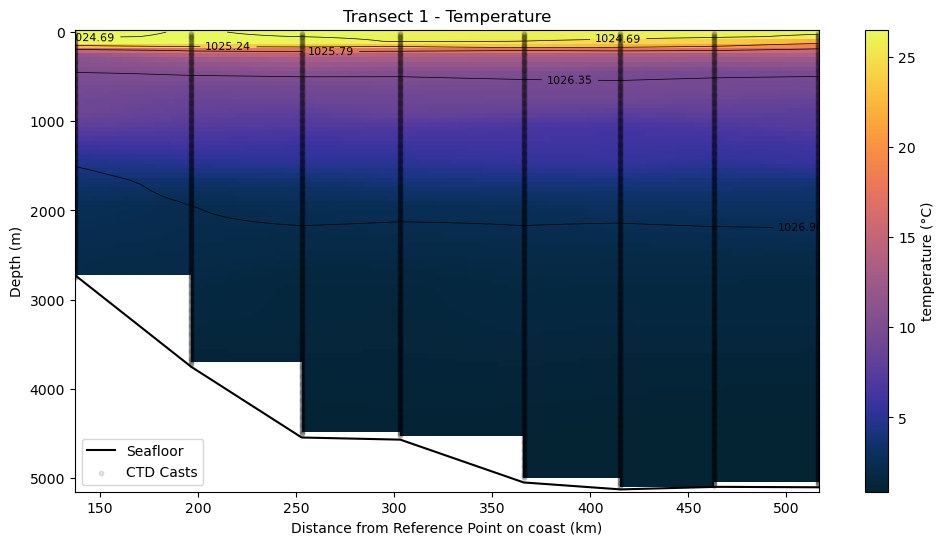

--- Debug: Shallowest Measurement Depths for Transect 2 ---
Station 1 at 75.27 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.57 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 185.30 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 240.99 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 299.33 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 352.67 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 418.36 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 481.01 km: Shallowest depth = 11.00 m
------------------------------------------------------------


c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


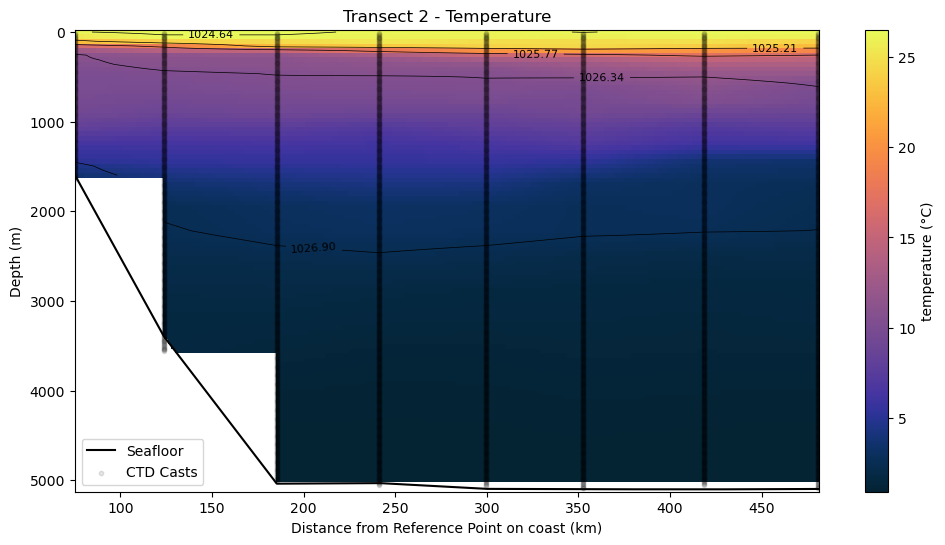

--- Debug: Shallowest Measurement Depths for Transect 3 ---
Station 1 at 58.78 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.91 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 192.09 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 263.97 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 329.52 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 408.34 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 492.59 km: Shallowest depth = 11.00 m
------------------------------------------------------------


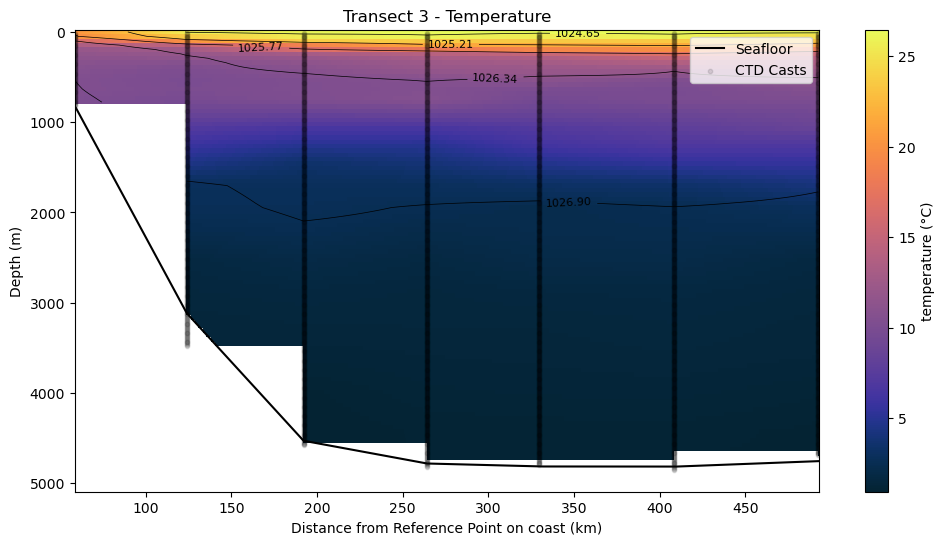

--- Debug: Shallowest Measurement Depths for Transect 1 ---
Station 1 at 137.42 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 196.45 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 252.93 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 303.19 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 366.05 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 415.13 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 463.08 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 516.39 km: Shallowest depth = 11.00 m
------------------------------------------------------------


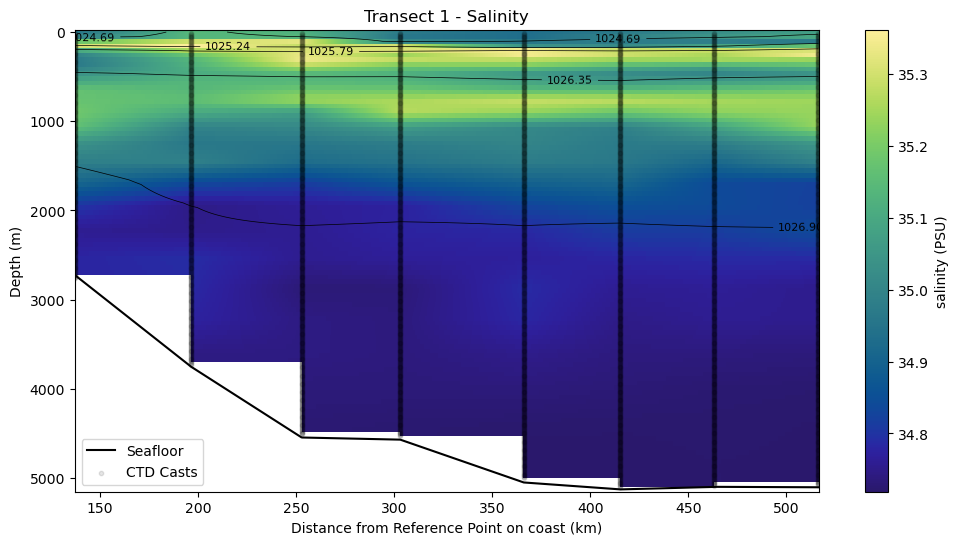

--- Debug: Shallowest Measurement Depths for Transect 2 ---
Station 1 at 75.27 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.57 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 185.30 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 240.99 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 299.33 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 352.67 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 418.36 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 481.01 km: Shallowest depth = 11.00 m
------------------------------------------------------------


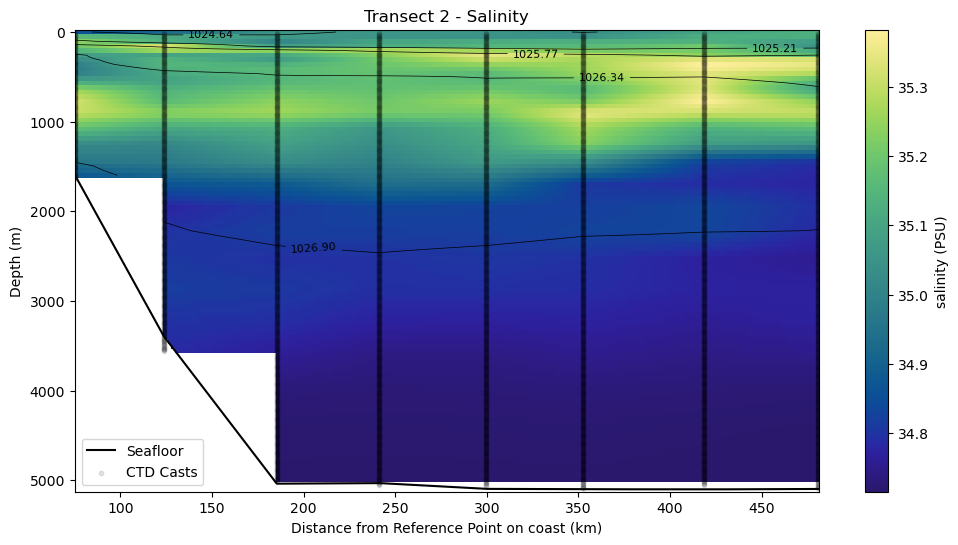

--- Debug: Shallowest Measurement Depths for Transect 3 ---
Station 1 at 58.78 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.91 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 192.09 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 263.97 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 329.52 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 408.34 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 492.59 km: Shallowest depth = 11.00 m
------------------------------------------------------------


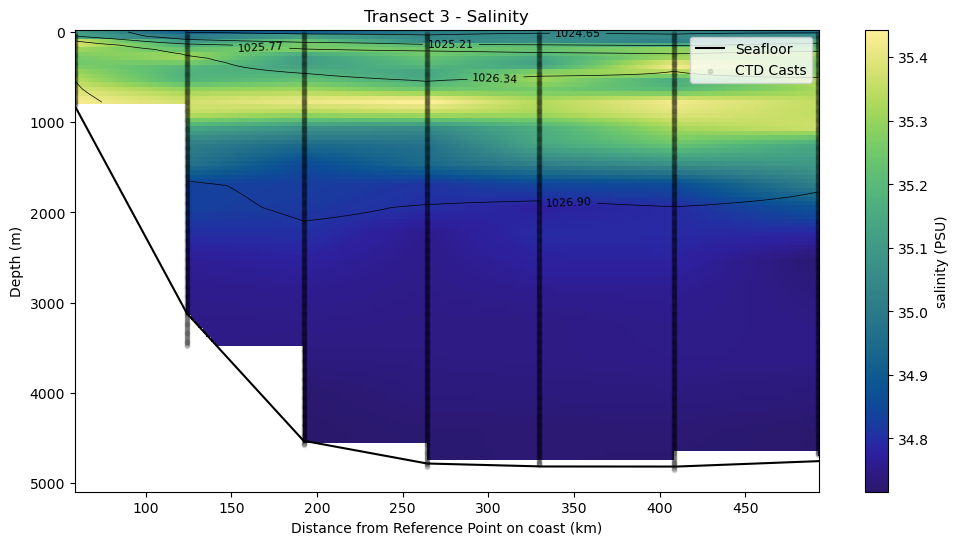

--- Debug: Shallowest Measurement Depths for Transect 1 ---
Station 1 at 137.42 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 196.45 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 252.93 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 303.19 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 366.05 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 415.13 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 463.08 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 516.39 km: Shallowest depth = 11.00 m
------------------------------------------------------------


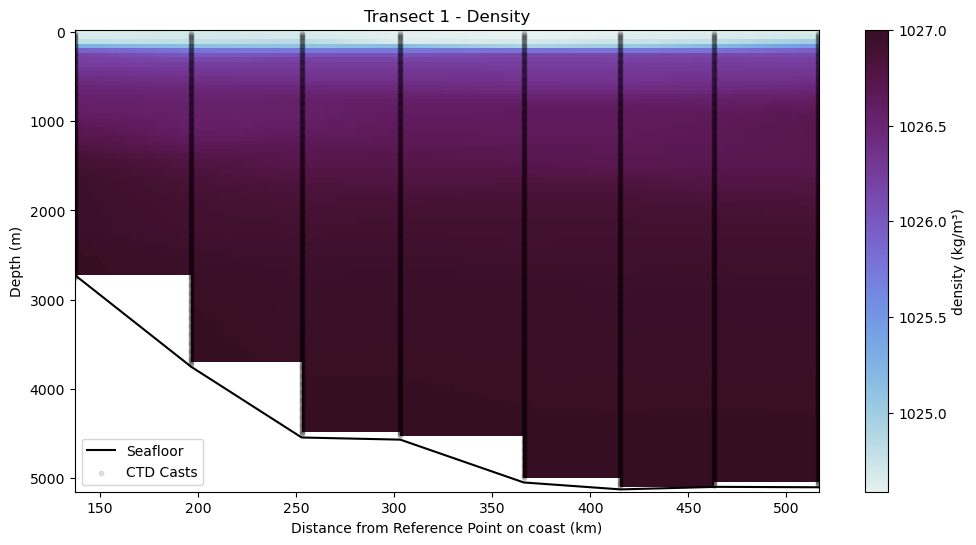

--- Debug: Shallowest Measurement Depths for Transect 2 ---
Station 1 at 75.27 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.57 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 185.30 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 240.99 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 299.33 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 352.67 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 418.36 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 8 at 481.01 km: Shallowest depth = 11.00 m
------------------------------------------------------------


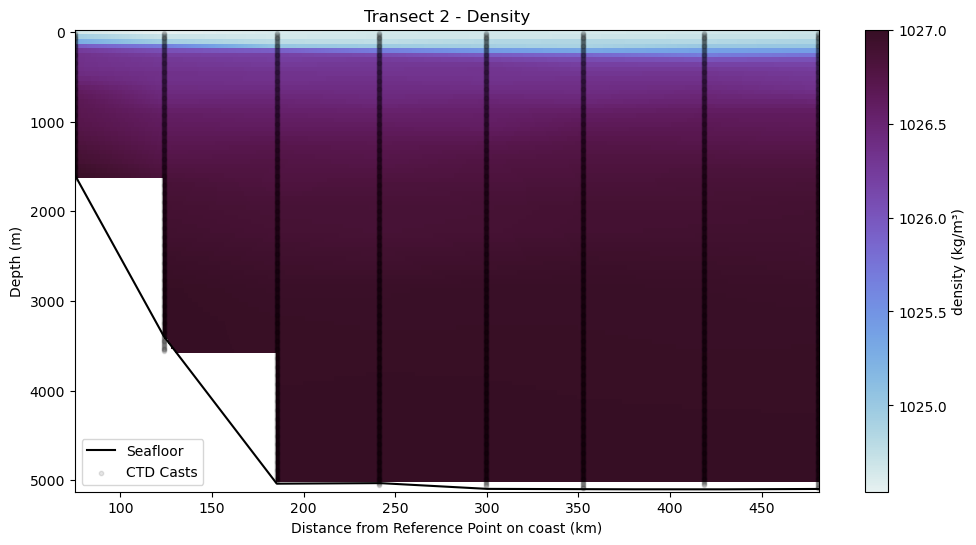

--- Debug: Shallowest Measurement Depths for Transect 3 ---
Station 1 at 58.78 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 2 at 123.91 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 3 at 192.09 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 4 at 263.97 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 5 at 329.52 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 6 at 408.34 km: Shallowest depth = 11.00 m
------------------------------------------------------------
Station 7 at 492.59 km: Shallowest depth = 11.00 m
------------------------------------------------------------


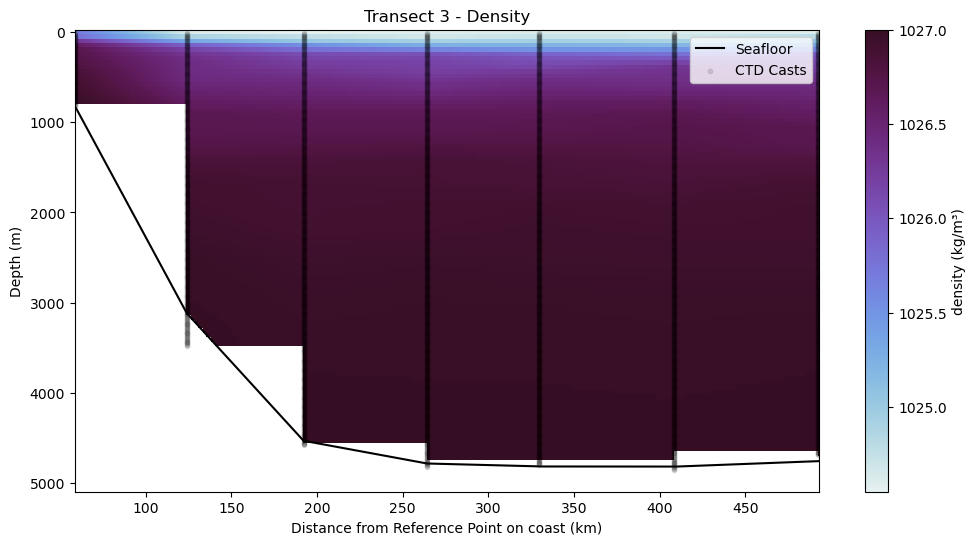

In [76]:
from geopy.distance import geodesic
from scipy.interpolate import griddata
# First load your bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Then plot cross-sections
transect_ids = [1, 2, 3]  # Your actual transect IDs
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='salinity')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='density')

In [ ]:
from geopy.distance import geodesic
from scipy.interpolate import griddata
import cmocean
import matplotlib.colors as mcolors

def compute_transect_fields(profiles, common_depth, reference_depth=2000, max_transport_depth=None):
    """
    For each transect, compute fields that are used for both transport and plotting:
      - Station distances (in m and km) computed relative to a reference (shore) point.
      - Density interpolated onto the common depth grid.
      - Geostrophic velocity computed via the thermal wind balance.
      - Transport per station and total transport.
    
    Parameters:
        profiles (list): List of profile dictionaries (each must include
                         'transect_id', 'lat', 'lon', 'depth', and 'density').
        common_depth (1D array): Common depth grid for interpolation and integration.
        reference_depth (float): Depth (m) at which the velocity is set to zero.
    
    Returns:
        dict: Dictionary keyed by transect ID containing:
              - 'profiles': The (possibly re-ordered) profiles used.
              - 'x_transect_m': Station distances in meters.
              - 'x_transect_km': Station distances in kilometers.
              - 'density_interp': Array of density profiles (n_stations x n_depth).
              - 'u': Geostrophic velocity field (m/s) on the common depth grid.
              - 'transport_per_station': Volume transport per station (m³/s).
              - 'total_transport': Total transport (m³/s) along the transect.
              - 'mean_lat': Mean latitude for the transect.
              - 'f': Computed Coriolis parameter.
    """
    # Constants
    g = 9.81      # m/s²
    rho0 = 1027   # kg/m³
    omega = 7.2921e-5  # rad/s
    
    # Define reference (shore) coordinates for transects 1, 2, and 3 (as (lat, lon))
    ref_points = {
        1: (4.97, 48.21),
        2: (7.29, 49.54),
        3: (9.31, 50.72)
    }
    
    # Group profiles by transect
    transect_groups = {}
    for p in profiles:
        tid = p['transect_id']
        if tid not in transect_groups:
            transect_groups[tid] = []
        transect_groups[tid].append(p)
    
    computed = {}
    for tid, t_profiles in transect_groups.items():
        print(f"\nProcessing Transect {tid}")
        # For transect 2 (east-west) reverse order if measurements were taken in opposite order
        if tid == 2:
            t_profiles = t_profiles[::-1]
        
        # Determine reference coordinate (use provided ref_points if available)
        if tid in ref_points:
            ref_coord = ref_points[tid]
        else:
            ref_coord = (t_profiles[0]['lat'], t_profiles[0]['lon'])
        
        # Compute station distances relative to the reference point (in meters)
        x_transect_m = np.array([
            geodesic((p['lat'], p['lon']), ref_coord).meters for p in t_profiles
        ])
        x_transect_km = x_transect_m / 1000.0
        
        # Interpolate density for each profile onto the common depth grid.
        density_list = []
        for p in t_profiles:
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            depths_sorted = np.array(depths)[order]
            dens_sorted = np.array(p['density'])[order]
            dens_interp = np.interp(common_depth, depths_sorted, dens_sorted,
                                    left=dens_sorted[0], right=dens_sorted[-1])
            density_list.append(dens_interp)
        density_interp = np.array(density_list)  # shape: (n_stations, n_depth)
        
        # Compute mean latitude and Coriolis parameter for the transect.
        transect_lats = [p['lat'] for p in t_profiles]
        mean_lat = np.mean(transect_lats)
        f = 2 * omega * np.sin(np.deg2rad(mean_lat))
        print(f"Mean latitude: {mean_lat:.4f}°, Coriolis: {f:.3e} s⁻¹")
        
        # Compute horizontal gradient of density (using x_transect in meters)
        drho_dx = np.gradient(density_interp, x_transect_m, axis=0)
        
        # Thermal wind balance: du/dz = (g/(rho0*f)) * drho_dx
        # (Sign convention: velocity increases if density decreases in the x-direction.)
        du_dz = (g / (rho0 * f)) * drho_dx
        
        # Integrate vertically to get geostrophic velocity, u (m/s)
        dz = np.gradient(common_depth)
        u = np.cumsum(du_dz * dz, axis=1)
        # Zero velocity at the reference depth.
        ref_idx = np.argmin(np.abs(common_depth - reference_depth))
        u = u - u[:, ref_idx][:, np.newaxis]
        
        # Compute volume transport per station (m³/s) by integrating u over depth.
        #transport_per_station = np.trapz(u, x=common_depth, axis=1)
        #total_transport = np.trapz(transport_per_station, x=x_transect_m)
        #I suspect this is wrong
        
        computed[tid] = {
            'profiles': t_profiles,
            'x_transect_m': x_transect_m,
            'x_transect_km': x_transect_km,
            'density_interp': density_interp,
            'u': u,
            #'transport_per_station': transport_per_station,
            #'total_transport': total_transport,
            'mean_lat': mean_lat,
            'f': f
        }
    return computed


In [100]:
def plot_velocity_section(computed_fields, bathy, common_depth, n_interp=100, deepest=None):
    """
    Plot the geostrophic velocity section for each transect using precomputed fields.
    
    Parameters:
        computed_fields (dict): Output from compute_transect_fields keyed by transect ID.
        bathy: Bathymetry dataset with an 'elevation' variable.
        common_depth (1D array): Common depth grid.
        n_interp (int): Number of horizontal interpolation points for the velocity grid.
        deepest (float/None): Maximum integration depth in meters (None=full depth).
    """
    norm = mcolors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
    cmap = cmocean.cm.balance
    
    for tid, fields in computed_fields.items():
        t_profiles = fields['profiles']
        x_transect_km = fields['x_transect_km']
        u = fields['u']
        
        # ==================== Bathymetry & Velocity Masking ====================
        # Get station bathymetry and mask velocities below seafloor
        station_bathy = []
        u_masked = np.zeros_like(u)
        for i, p in enumerate(t_profiles):
            elev = bathy.elevation.sel(lon=p['lon'], lat=p['lat'], method="nearest").values
            seafloor_depth = -elev if elev < 0 else elev
            station_bathy.append(seafloor_depth)
            depth_mask = common_depth <= seafloor_depth
            u_masked[i, :] = np.where(depth_mask, u[i, :], np.nan)
        
        station_bathy = np.array(station_bathy)
        
        # ==================== Interpolation Setup ====================
        xi = np.linspace(x_transect_km[0], x_transect_km[-1], n_interp)
        xi_grid, zi_grid = np.meshgrid(xi, common_depth)
        x_points = np.repeat(x_transect_km, len(common_depth))
        z_points = np.tile(common_depth, len(t_profiles))
        
        # Interpolate bathymetry
        bathy_interp = griddata(x_transect_km, station_bathy, xi, method='linear')
        
        # Interpolate velocity field (using pre-masked velocities)
        velocity_grid = griddata((x_points, z_points), u_masked.flatten(),
                                 (xi_grid, zi_grid), method='linear')
        velocity_grid_masked = np.where(zi_grid > bathy_interp, np.nan, velocity_grid)
        
        # ==================== Temperature Interpolation ====================
        # Extract temperature data
        temp_x_points, temp_z_points, temp_values = [], [], []
        for i, p in enumerate(t_profiles):
            station_x = x_transect_km[i]
            depths = np.abs(p['depth'])
            temps = p['temperature']
            temp_x_points.extend([station_x] * len(depths))
            temp_z_points.extend(depths)
            temp_values.extend(temps)
        
        # Interpolate temperature to grid
        temperature_grid = griddata((temp_x_points, temp_z_points), temp_values,
                                    (xi_grid, zi_grid), method='linear')
        
        # ==================== Transport Calculations ====================
        xi_m = xi * 1000.0  # Convert to meters
        velocity_grid_filled = np.nan_to_num(velocity_grid_masked, nan=0.0)
        
        # Determine integration depth limits
        integration_depth = common_depth.copy()
        if deepest is not None:
            integration_depth = integration_depth[integration_depth <= deepest]
        
        # Vertical integration
        transport_per_x = np.trapz(
            velocity_grid_filled[:len(integration_depth), :],
            x=integration_depth,
            axis=0
        )
        
        # Horizontal integration
        total_transport_interp = np.trapz(transport_per_x, x=xi_m)
        total_transport_Sv = total_transport_interp / 1e6
        print(f"Transect {tid}: Total Transport = {total_transport_Sv:.3f} Sv")
        #mass transport
        density_flat = fields['density_interp'].flatten()
        density_grid = griddata((x_points, z_points), density_flat,
                                (xi_grid, zi_grid), method='linear')
        density_grid_filled = np.nan_to_num(density_grid, nan=0.0)
        
        mass_transport_per_x = np.zeros_like(xi)
        for i in range(len(xi)):
            valid_depths = (common_depth <= bathy_interp[i]) & (common_depth <= deepest if deepest else True)
            if np.any(valid_depths):
                mass_transport_per_x[i] = np.trapz(
                    density_grid_filled[valid_depths, i] * velocity_grid_filled[valid_depths, i],
                    x=common_depth[valid_depths]
                )
        
        total_mass_transport = np.trapz(mass_transport_per_x, x=xi_m)
        if deepest is None:
            print(f"Transect {tid}: Total Mass Transport = {total_mass_transport:.3f} kg/s")
        else:
            print(f"Transect {tid}: Mass Transport in first {deepest} m = {total_mass_transport:.3f} kg/s")
        # ==================== Plotting ====================
        # Full depth plot
        plt.figure(figsize=(12, 6))
        pcm = plt.pcolormesh(xi_grid, common_depth, velocity_grid_masked,
                             cmap=cmap, norm=norm, shading='auto')
        plt.colorbar(pcm, label='Velocity (m/s)')
        plt.plot(xi, bathy_interp, 'k-', lw=2, label='Seafloor')
        # Plot CTD measurement sites.
        meas_x, meas_y = [], []
        for distance, p, st_depth in zip(x_transect_km, t_profiles, station_bathy):
            depths = np.abs(p['depth'])
            valid = depths <= st_depth
            if np.any(valid):
                meas_x.extend(np.repeat(distance, np.sum(valid)))
                meas_y.extend(depths[valid])
        plt.scatter(meas_x, meas_y, c='k', alpha=0.01, s=10, label='CTD Measurements')
        plt.gca().invert_yaxis()
        plt.title(f'Transect {tid} - Full Depth')
        plt.show()
        print(f"Transect {tid}: Maximum Velocity = {np.nanmax(velocity_grid_masked):.3f} m/s")
        """
        # Top layer plot with isotherms
        plt.figure(figsize=(12, 6))
        
        # Determine plot depth limit
        plot_depth = deepest if deepest is not None else 150
        depth_mask = zi_grid <= plot_depth
        
        # Velocity plot
        pcm = plt.pcolormesh(xi_grid, common_depth, np.where(depth_mask, velocity_grid_masked, np.nan),
                             cmap=cmap, norm=norm, shading='auto')
        plt.colorbar(pcm, label='Velocity (m/s)')
        
        # Isotherms (only in top layer)
        temp_masked = np.where(depth_mask, temperature_grid, np.nan)
        if np.any(~np.isnan(temp_masked)):
            levels = np.linspace(np.nanmin(temp_masked), np.nanmax(temp_masked), 8)
            cs = plt.contour(xi_grid, zi_grid, temp_masked, levels=levels,
                             colors='k', linewidths=0.8)
            plt.clabel(cs, inline=True, fmt='%1.1f')
        
        plt.ylim(plot_depth, 0)
        plt.title(f'Transect {tid} - Top {plot_depth}m')
        plt.show()
        """


Processing Transect 1
Mean latitude: 4.8625°, Coriolis: 1.236e-05 s⁻¹

Processing Transect 2
Mean latitude: 7.0801°, Coriolis: 1.798e-05 s⁻¹

Processing Transect 3
Mean latitude: 9.1225°, Coriolis: 2.312e-05 s⁻¹
Transect 1: Total Transport = -22.355 Sverdrups
Transect 2: Total Transport = 44.983 Sverdrups
Transect 3: Total Transport = 133.322 Sverdrups


C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\4253021914.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\4253021914.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect_m)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\653906580.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_x = np.trapz(
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\653906580.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport_interp

Transect 1: Total Transport = 6.693 Sv
Transect 1: Mass Transport in first 150 m = 6858582814.757 kg/s


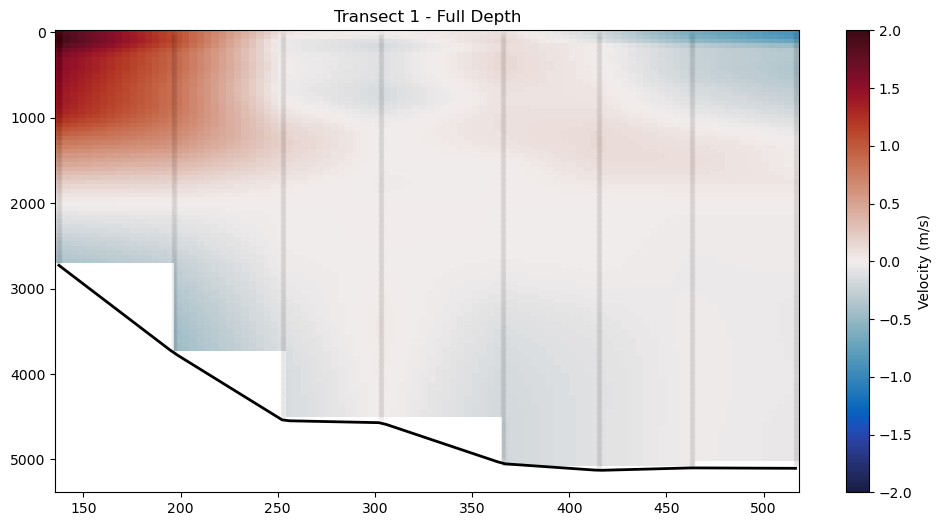

Transect 1: Maximum Velocity = 1.947 m/s
Transect 2: Total Transport = 22.932 Sv
Transect 2: Mass Transport in first 150 m = 23500204928.839 kg/s


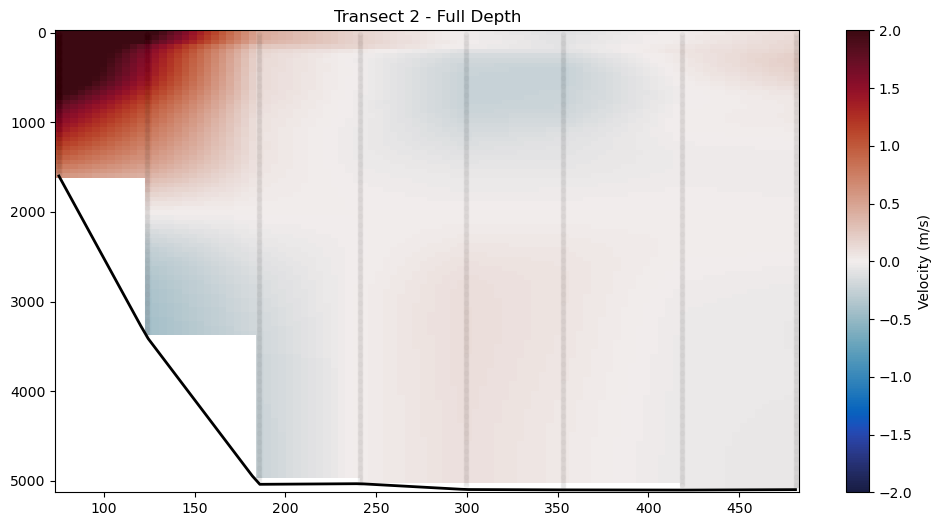

Transect 2: Maximum Velocity = 3.298 m/s
Transect 3: Total Transport = 33.479 Sv
Transect 3: Mass Transport in first 150 m = 34323996119.079 kg/s


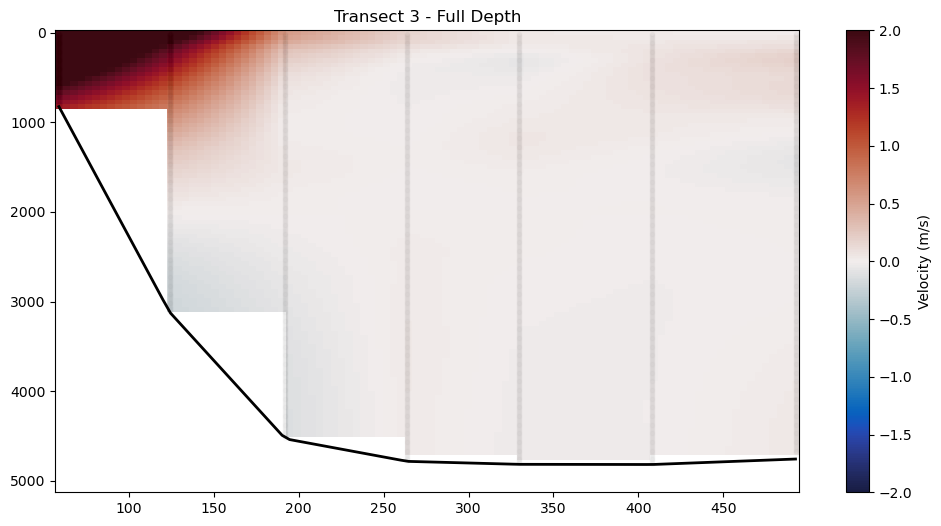

Transect 3: Maximum Velocity = 4.011 m/s


In [ ]:
max_depth = max([np.max(np.abs(p['depth'])) for p in profiles])
common_depth = np.linspace(0, max_depth, 100)  # Define as appropriate.
computed_fields = compute_transect_fields(profiles, common_depth, reference_depth=2000)
# After computing the transect fields, add the following snippet in cell 14:


plot_velocity_section(computed_fields, bathy, common_depth, n_interp=100, deepest=150)


In [80]:
""" 
We consider everything below here to be junk I guess. not important anymore. 
"""
def compute_mass_transport_from_fields(computed_fields, common_depth):
    """
    For each transect in computed_fields, calculate the mass transport (kg/s) by
    integrating (velocity * density) over depth and horizontally. This re‑uses
    the precomputed fields (u, density_interp, and x_transect_m) so that the velocity
    is not recalculated.
    
    Parameters:
        computed_fields (dict): Dictionary (keyed by transect ID) from compute_transect_fields.
            Must contain keys:
              - 'u': Geostrophic velocity field (shape: n_stations x n_depth).
              - 'density_interp': Interpolated density field (same shape).
              - 'x_transect_m': Station distances (in meters).
        common_depth (1D array): The common depth grid used for integration.
        
    Returns:
        dict: The updated computed_fields dictionary with added keys:
              - 'mass_transport_per_station': Mass transport per station (kg/s).
              - 'total_mass_transport': Total mass transport (kg/s) for the transect.
    """
    for tid, fields in computed_fields.items():
        # u and density_interp have shape (n_stations, n_depth)
        u = fields['u']
        density_interp = fields['density_interp']
        x_transect_m = fields['x_transect_m']
        
        # Compute mass flux per station by integrating (u * density) over depth.
        transport_per_station = np.trapz(u * density_interp, x=common_depth, axis=1)
        # Integrate horizontally to obtain total mass transport.
        total_mass_transport = np.trapz(transport_per_station, x=x_transect_m)
        
        fields['mass_transport_per_station'] = transport_per_station
        fields['total_mass_transport'] = total_mass_transport
    return computed_fields

def plot_transect_mass_transport_from_fields(computed_fields):
    """
    Plots mass transport per station and the total mass transport for each transect.
    This function uses the precomputed fields (including mass transport) from 
    compute_mass_transport_from_fields.
    
    Parameters:
        computed_fields (dict): Dictionary (keyed by transect ID) that contains:
            - 'x_transect_km': Station distances (in km) for plotting.
            - 'mass_transport_per_station': Mass transport (kg/s) per station.
            - 'total_mass_transport': Total mass transport (kg/s) for the transect.
    """
    import matplotlib.pyplot as plt
    
    for tid, fields in computed_fields.items():
        x_transect_km = fields['x_transect_km']
        transport_per_station = fields['mass_transport_per_station']
        total_mass_transport = fields['total_mass_transport']
        
        # Choose the appropriate x-axis label (for Transect 2 we use the eastmost reference)
        xlabel = 'Distance from eastmost reference point (km)' if tid == 2 else 'Distance from westmost reference point (km)'
        
        plt.figure(figsize=(8, 5))
        plt.plot(x_transect_km, transport_per_station, 'o-', label='Mass Transport per Station')
        plt.xlabel(xlabel)
        plt.ylabel('Mass Transport per Station (kg/s)')
        plt.title(f'Transect {tid}\nTotal Mass Transport = {total_mass_transport:.2e} kg/s')
        plt.grid(True)
        plt.legend()
        plt.show()


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

def plot_transect_mass_transport(profiles, mass_transport_results, common_depth):
    """
    Plots the mass transport per station and total mass transport for each transect.
    The horizontal station distances (x‑axis) are computed relative to the reference
    (shore) points rather than the first station along the transect.
    
    Parameters:
        profiles (list): List of processed profiles (each with 'transect_id', 'lat', 'lon', etc.).
        mass_transport_results (dict): Dictionary from calculate_mass_transport containing for each transect:
            - 'u': geostrophic velocity field (m/s) on the common depth grid.
            - 'density_interp': interpolated density field (kg/m³) on the common depth grid.
            - 'mass_transport': total mass transport (kg/s) computed earlier.
        common_depth (1D array): The common depth grid used in the integration.
    """
    # Define reference (shore) coordinates for each transect (as (lat, lon))
    ref_points = {
        1: (4.97, 48.21),
        2: (7.29, 49.54),
        3: (9.31, 50.72)
    }
    
    # Process each transect using its mass transport result
    for tid, result in mass_transport_results.items():
        # Extract the profiles for this transect
        transect_profiles = [p for p in profiles if p['transect_id'] == tid]
        if not transect_profiles:
            continue
        
        # Determine the reference coordinate (if available, else use first profile)
        if tid in ref_points:
            ref_coord = ref_points[tid]
        else:
            ref_coord = (transect_profiles[0]['lat'], transect_profiles[0]['lon'])
        
        # Compute station distances relative to the reference point (in meters)
        x_transect_m = np.array([
            geodesic((p['lat'], p['lon']), ref_coord).meters for p in transect_profiles
        ])
        x_transect_km = x_transect_m / 1000.0  # convert to kilometers for plotting
        
        # Use the previously computed fields from mass_transport_results:
        # u: geostrophic velocity (n_stations x n_depth)
        # density_interp: interpolated density (n_stations x n_depth)
        u = result['u']
        density_interp = result['density_interp']
        
        # Recompute the transport per station by integrating (u*density) over depth
        transport_per_station = np.trapz(u * density_interp, x=common_depth, axis=1)
        total_mass_transport = np.trapz(transport_per_station, x=x_transect_m)
        
        plt.figure(figsize=(8, 5))
        plt.plot(x_transect_km, transport_per_station, 'o-', label='Mass Transport per Station')
        plt.xlabel("Distance from reference point (km)")
        plt.ylabel("Mass Transport per Station (kg/s)")
        plt.title(f"Transect {tid}\nTotal Mass Transport = {total_mass_transport:.2e} kg/s")
        plt.grid(True)
        plt.legend()
        plt.show()



Processing Transect 1
Mean latitude: 4.8625°, Coriolis: 1.236e-05 s⁻¹

Processing Transect 2
Mean latitude: 7.0801°, Coriolis: 1.798e-05 s⁻¹

Processing Transect 3
Mean latitude: 9.1225°, Coriolis: 2.312e-05 s⁻¹


C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\4253021914.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\4253021914.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect_m)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\2746520304.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u * density_interp, x=common_depth, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_16208\2746520304.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration funct

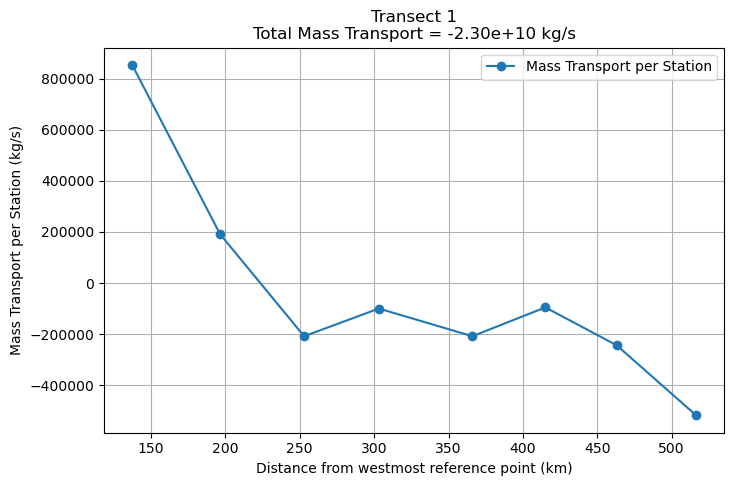

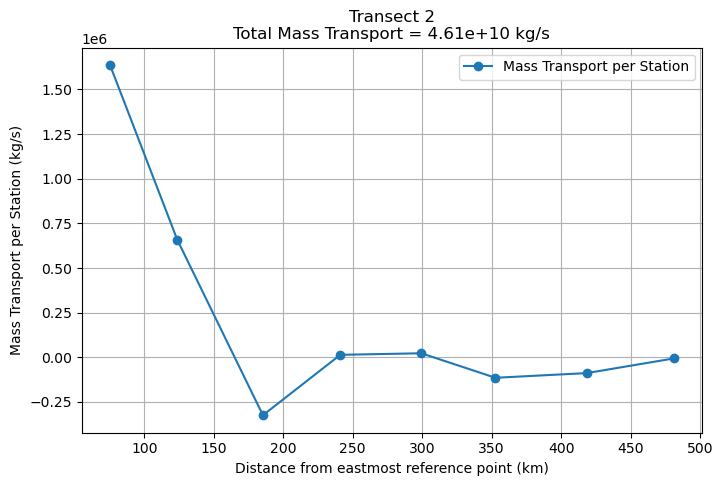

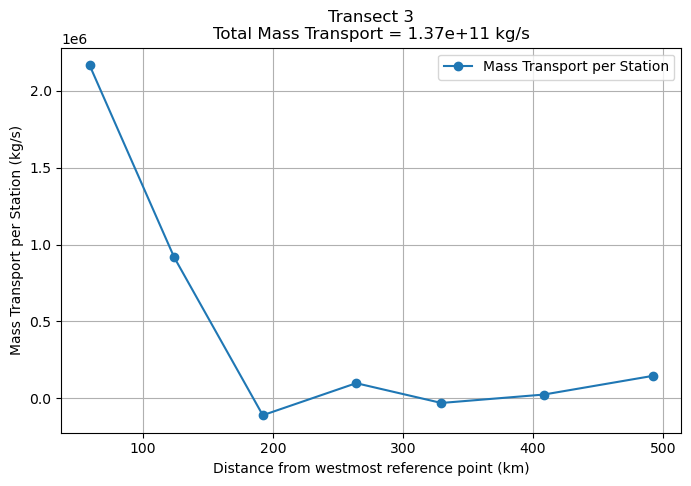

In [82]:
max_depth = max([np.max(np.abs(p['depth'])) for p in profiles])
common_depth = np.linspace(0, max_depth, 100)  # Define max_depth from your data or as desired.
computed_fields = compute_transect_fields(profiles, common_depth, reference_depth=2000)
computed_fields = compute_mass_transport_from_fields(computed_fields, common_depth)
plot_transect_mass_transport_from_fields(computed_fields)
